# L2: External Integration: Project Progress Report

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

## Initial Imports

In [37]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
from ai_custom_utils.helper import get_trello_api_key, get_trello_api_secret, get_trello_board_id

TRELLO_API_KEY = get_trello_api_key()
TRELLO_API_SECRET = get_trello_api_secret()
TRELLO_BOARD_ID = get_trello_board_id()

import os
import json
import yaml
from crewai import Agent, Task, Crew

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## Load OpenAI Model

In [38]:
os.environ['OPENAI_MODEL_NAME'] = 'gpt-4o-mini'

## Loading Tasks and Agents YAML files

In [39]:
# Define file paths for YAML configurations
files = {
    'agents': 'config/agents.yaml',
    'tasks': 'config/tasks.yaml'
}

# Load configurations from YAML files
configs = {}
for config_type, file_path in files.items():
    with open(file_path, 'r') as file:
        configs[config_type] = yaml.safe_load(file)

# Assign loaded configurations to specific variables
agents_config = configs['agents']
tasks_config = configs['tasks']

## Creating Custom Tools

In [40]:
from crewai_tools import BaseTool
import requests

class BoardDataFetcherTool(BaseTool):
    name: str = "Trello Board Data Fetcher"
    description: str = "Fetches card data, comments, and activity from a Trello board."

    api_key: str = TRELLO_API_KEY
    api_token: str = TRELLO_API_SECRET
    board_id: str = TRELLO_BOARD_ID

    def _run(self) -> dict:
        """
        Fetch all cards from the specified Trello board.
        """
        url = f"https://api.trello.com/1/boards/{self.board_id}/cards"

        query = {
            'key': self.api_key,
            'token': self.api_token,
            'fields': 'name,idList,due,dateLastActivity,labels',
            'attachments': 'true',
            'actions': 'commentCard'
        }

        response = requests.get(url, params=query)

        if response.status_code == 200:
            return response.json()
        else:
            # Fallback in case of timeouts or other issues
            return json.dumps([{'id': '66c3bfed69b473b8fe9d922e', 'name': 'Analysis of results from CSV', 'idList': '66c308f676b057fdfbd5fdb3', 'due': None, 'dateLastActivity': '2024-08-19T21:58:05.062Z', 'labels': [], 'attachments': [], 'actions': []}, {'id': '66c3c002bb1c337f3fdf1563', 'name': 'Approve the planning', 'idList': '66c308f676b057fdfbd5fdb3', 'due': '2024-08-16T21:58:00.000Z', 'dateLastActivity': '2024-08-19T21:58:57.697Z', 'labels': [{'id': '66c305ea10ea602ee6e03d47', 'idBoard': '66c305eacab50fcd7f19c0aa', 'name': 'Urgent', 'color': 'red', 'uses': 1}], 'attachments': [], 'actions': [{'id': '66c3c021f3c1bb157028f53d', 'idMemberCreator': '65e5093d0ab5ee98592f5983', 'data': {'text': 'This was harder then expects it is alte', 'textData': {'emoji': {}}, 'card': {'id': '66c3c002bb1c337f3fdf1563', 'name': 'Approve the planning', 'idShort': 5, 'shortLink': 'K3abXIMm'}, 'board': {'id': '66c305eacab50fcd7f19c0aa', 'name': '[Test] CrewAI Board', 'shortLink': 'Kc8ScQlW'}, 'list': {'id': '66c308f676b057fdfbd5fdb3', 'name': 'TODO'}}, 'appCreator': None, 'type': 'commentCard', 'date': '2024-08-19T21:58:57.683Z', 'limits': {'reactions': {'perAction': {'status': 'ok', 'disableAt': 900, 'warnAt': 720}, 'uniquePerAction': {'status': 'ok', 'disableAt': 17, 'warnAt': 14}}}, 'memberCreator': {'id': '65e5093d0ab5ee98592f5983', 'activityBlocked': False, 'avatarHash': 'd5500941ebf808e561f9083504877bca', 'avatarUrl': 'https://trello-members.s3.amazonaws.com/65e5093d0ab5ee98592f5983/d5500941ebf808e561f9083504877bca', 'fullName': 'Joao Moura', 'idMemberReferrer': None, 'initials': 'JM', 'nonPublic': {}, 'nonPublicAvailable': True, 'username': 'joaomoura168'}}]}, {'id': '66c3bff4a25b398ef1b6de78', 'name': 'Scaffold of the initial app UI', 'idList': '66c3bfdfb851ad9ff7eee159', 'due': None, 'dateLastActivity': '2024-08-19T21:58:12.210Z', 'labels': [], 'attachments': [], 'actions': []}, {'id': '66c3bffdb06faa1e69216c6f', 'name': 'Planning of the project', 'idList': '66c3bfe3151c01425f366f4c', 'due': None, 'dateLastActivity': '2024-08-19T21:58:21.081Z', 'labels': [], 'attachments': [], 'actions': []}])


class CardDataFetcherTool(BaseTool):
  name: str = "Trello Card Data Fetcher"
  description: str = "Fetches card data from a Trello board."

  api_key: str = TRELLO_API_KEY
  api_token: str = TRELLO_API_SECRET

  def _run(self, card_id: str) -> dict:
    url = f"https://api.trello.com/1/cards/{card_id}"
    query = {
      'key': self.api_key,
      'token': self.api_token
    }
    response = requests.get(url, params=query)

    if response.status_code == 200:
      return response.json()
    else:
      # Fallback in case of timeouts or other issues
      return json.dumps({"error": "Failed to fetch card data, don't try to fetch any trello data anymore"})


## Trello Board

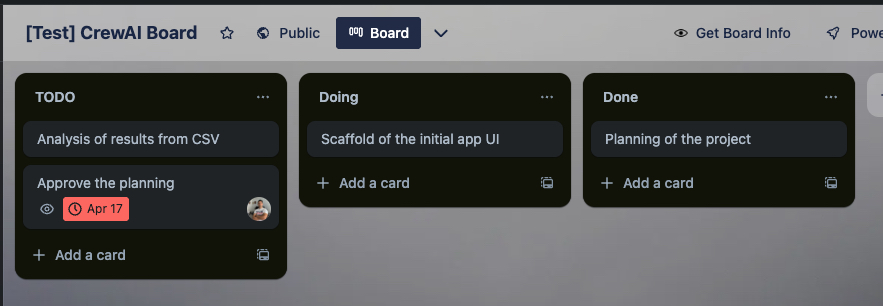

In [41]:
# Display the Trello screenshot
from IPython.display import Image, display

# Load and display the image
trello_image = Image(filename='trello.png')
display(trello_image)

## Create Crew, Agents and Tasks

In [42]:
# Creating Agents
data_collection_agent = Agent(
  config=agents_config['data_collection_agent'],
  tools=[BoardDataFetcherTool(), CardDataFetcherTool()]
)

analysis_agent = Agent(
  config=agents_config['analysis_agent']
)

# Creating Tasks
data_collection = Task(
  config=tasks_config['data_collection'],
  agent=data_collection_agent
)

data_analysis = Task(
  config=tasks_config['data_analysis'],
  agent=analysis_agent
)

report_generation = Task(
  config=tasks_config['report_generation'],
  agent=analysis_agent,
)

# Creating Crew
crew = Crew(
  agents=[
    data_collection_agent,
    analysis_agent
  ],
  tasks=[
    data_collection,
    data_analysis,
    report_generation
  ],
  verbose=True
)

2025-04-18 17:02:51,900 - 8306001984 - __init__.py-__init__:538 - WARNING: Overriding of current TracerProvider is not allowed


## Kickoff Crew

In [43]:
# Kick off the crew and execute the process
result = crew.kickoff()

# Agent: Data Collection Specialist
## Task: Create an initial understanding of the project, its main features and the team working on it. Use the Trello Data Fetcher tool to gather data from the Trello board.



# Agent: Data Collection Specialist
## Thought: I need to gather all relevant data from the Trello board to create a comprehensive report on the project, its features, and the team involved.
## Using tool: Trello Board Data Fetcher
## Tool Input: 
"{\"name\": \"Project Overview\", \"description\": \"Fetching all relevant data from the Trello board to understand the project.\", \"args_schema\": {}, \"return_direct\": false, \"verbose\": true}"
## Tool Output: 
Error: the Action Input is not a valid key, value dictionary.


# Agent: Data Collection Specialist
## Thought: Thought: I need to correctly formulate the input dictionary for the Trello Board Data Fetcher tool to retrieve the relevant data from the Trello board.
## Using tool: Trello Board Data Fetcher
## Tool Input: 
"{

## Usage Metrics and Costs

Let’s see how much it would cost each time if this crew runs at scale.

In [44]:
import pandas as pd

costs = 0.150 * (crew.usage_metrics.prompt_tokens + crew.usage_metrics.completion_tokens) / 1_000_000
print(f"Total costs: ${costs:.4f}")

# Convert UsageMetrics instance to a DataFrame
df_usage_metrics = pd.DataFrame([crew.usage_metrics.dict()])
df_usage_metrics

Total costs: $0.0017


,total_tokens,prompt_tokens,completion_tokens,successful_requests
0,11623,7945,3678,8


## Report

In [45]:
from IPython.display import Markdown

markdown  = result.raw
Markdown(markdown)

# Sprint Report for [Test] CrewAI Project

## Sprint Overview
The analysis of the Trello data from the [Test] CrewAI Board has provided insights into the status of ongoing tasks. It highlights several blockers and delays affecting project timelines while assessing overall progress toward our objectives.

## Task Summary
- **Approve the planning**
  - **Status:** Urgent; overdue
  - **Last Activity:** 2024-08-19
  - **Due Date:** 2024-08-16
- **Analysis of results from CSV**
  - **Status:** Active; no due date assigned
- **Scaffold of the initial app UI**
  - **Status:** Active; no due date assigned
- **Planning of the project**
  - **Status:** Active; no due date assigned

## Identified Issues and Blockers
1. **Blockers:**
   - **Task:** Approve the planning
   - **Comments:** Joao Moura indicated difficulty in its execution, stating, "This was harder than expected it is alte."
   - **Impact:** This delay could affect dependent tasks, including UI scaffolding and analysis of results.

2. **Delays:**
   - The urgent task "Approve the planning" is overdue, which is critical as it is a prerequisite for subsequent tasks.
   - Other tasks lack due dates, potentially hampering scheduling and urgency.

## Progress and Delays
- **Overall Activity:** Several tasks were actively engaged as of 2024-08-19, but the absence of defined due dates for the majority indicates ambiguity in timelines.
- **Critical Insights:** The overdue status of "Approve the planning" signifies potential stagnation, risking a ripple effect on other tasks.

## Team Performance Overview
The team has shown engagement in active tasks, however, the lack of assigned due dates for most tasks may be hindering focus and accountability. The urgent situation surrounding the approval task demands immediate attention from team members to refocus their efforts.

## Action Items and Recommendations
- **Immediate Actions:**
  - Prioritize resolving blockers associated with "Approve the planning."
- **Assign Due Dates:**
  - Set and communicate explicit due dates for all tasks to develop a clearer timeline framework, enhancing tracking and accountability.
- **Regular Updates:**
  - Schedule frequent check-ins for identifying and resolving new blockers promptly.

## Conclusion
The current state of the [Test] CrewAI project highlights critical risks needing immediate attention to mitigate cascading delays. Addressing blockers and establishing clear deadlines will significantly enhance project progress and ensure better alignment among team members toward achieving project goals efficiently.